# This notebook will provide a preprocessing process to fed a pre trained Yolov5 model. The dataset used to do that can be found in Kaggle : https://www.kaggle.com/datasets/tannergi/chess-piece-detection

In [3]:
import os
import numpy as np
import PIL
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import struct
from sklearn.cluster import KMeans

# import tensorflow as tf
# from tensorflow.keras.applications.mobilenet import preprocess_input
# from tensorflow.keras import models
# from keras.models import Model
# from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, ZeroPadding2D
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [4]:
classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

In [5]:
def get_dataset_dicts(annotation_path, image_path, classes):
    dataset_dicts = []
    for filename in os.listdir(annotation_path):
        if filename != '.ipynb_checkpoints':
            record = {}
            root = ET.parse(os.path.join(annotation_path, filename)).getroot()
            record["file_name"] = os.path.join(image_path, root.find('filename').text)
            record["height"] = 2248
            record["width"] = 4000

            objs = []
            for member in root.findall('object'):
                obj = {
                  'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
                  'category_id': classes.index(member[0].text),
                  "iscrowd": 0}
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

In [6]:
dataset = get_dataset_dicts('Dataset\\detection\\annotations', 'Dataset\\detection\\images', classes)

## Loading and resizing images

In [24]:
img = []
for file in dataset:
    temp_img = PIL.Image.open(file['file_name'])
    temp_img = temp_img.resize((640,640),PIL.Image.ANTIALIAS)
    temp_img.save(file['file_name'])
    img.append(np.array(temp_img))
img = np.array(img)

C:\Users\thoma\AppData\Local\Temp\ipykernel_11884\4160845645.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  temp_img = temp_img.resize((640,640),PIL.Image.ANTIALIAS)


In [9]:
dataset[:5]

[{'file_name': 'Dataset\\detection\\images\\IMG_1989.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1780, 573, 2319, 1442],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1990.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1880, 1052, 2383, 1532],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1991.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1325, 1112, 1564, 1378],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1992.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1613, 342, 2001, 1098],
    'category_id': 1,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1993.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1795, 880, 2165, 1280],
    'category_id': 1,
    'iscrowd': 0}]}]

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


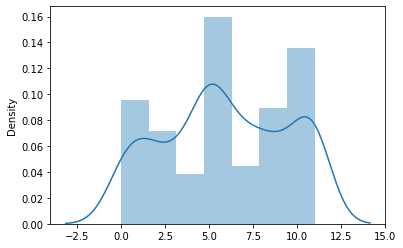

In [10]:
classification_ = np.array([piece['category_id'] for count in range(len(dataset)) for piece in dataset[count]['annotations']])
sns.distplot(classification_)
plt.show()

In [13]:
def convert_to_yolo_txt(dictionnary, path):
    
    for img in dictionnary:
        file_name = img["file_name"].split("\\")[-1][:-4]
        height, width = img["height"], img["width"]
        file = open(path + file_name + ".txt", "w") 
        for obj in img["annotations"]:
            bbox_width,  bbox_height = (obj["bbox"][2] - obj["bbox"][0])/width, (obj["bbox"][3] - obj["bbox"][1])/height
            x_center, y_center = obj["bbox"][0]/width + bbox_width/2, obj["bbox"][1]/height + bbox_height/2
            category = obj["category_id"]
            file.write(str(category) + " " +str(x_center) + " " +str(y_center) + " " + str(bbox_width) + " " + str(bbox_height)) 
            file.write('\n')
        file.close() 

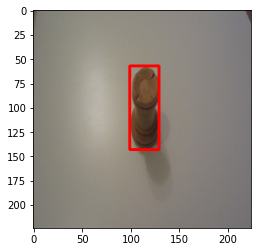

In [23]:
d = dataset[0]
height, width = d["height"], d["width"]
for obj in d["annotations"]:
    bbox_width,  bbox_height = (obj["bbox"][2] - obj["bbox"][0])/width, (obj["bbox"][3] - obj["bbox"][1])/height
    x_center, y_center = obj["bbox"][0]/width + bbox_width/2, obj["bbox"][1]/height + bbox_height/2
    category = obj["category_id"]
    plt.imshow(cv2.rectangle(img[0], (int((x_center - bbox_width/2)*224),int((y_center - bbox_height/2)*224)), (int((x_center + bbox_width/2)*224),int((y_center + bbox_height/2)*224)), (255,0,0), 2))
    plt.show()

In [14]:
convert_to_yolo_txt(dataset, "Dataset/detection/labels/")

The dataset is relatively unbalanced

In [87]:
height = np.mean(np.array([dataset[count]['height'] for count in range(len(dataset))]))
width = np.mean(np.array([dataset[count]['width'] for count in range(len(dataset))]))

print(height, width)

2248.0 4000.0


All images have the same dimension. So we will scale dimension of bounding box to be between [0,1]

## Training

In [ ]:
python train.py --img 640 --batch 16 --epochs 3 --data chess.yaml --weights yolov5s.pt

## Video prediction

In [ ]:
python detect.py --weights runs/train/exp6/weights/best.pt --source ../Dataset/detection/test_videos/video2.mp4